# The Boston Housing Dataset

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [1]:
# This command upgrades the 'numexpr' library using pip
!pip install --upgrade numexpr

# Step 1: Import Necessary Libraries

In [2]:
# Import necessary libraries and modules from SageMaker and boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
import boto3
import os
import matplotlib.pyplot as plt



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Step 2: Set Up SageMaker Session and Role

In [3]:
# Create a SageMaker session, which manages interactions with SageMaker services
sagemaker_session = sagemaker.Session()

# Get the IAM execution role used for SageMaker to access AWS resources
role = get_execution_role()

# Get the AWS region associated with the SageMaker session
region = sagemaker_session.boto_region_name


# Step 3: Prepare Your Data

In [4]:
# Import the pandas library as 'pd' for data manipulation and analysis
import pandas as pd

# Import the train_test_split function from scikit-learn for data splitting
from sklearn.model_selection import train_test_split


In [5]:
# Read data from the 'HousingData.csv' file into a pandas DataFrame called 'housing_data'
housing_data = pd.read_csv('HousingData.csv')


In [6]:
# Check for missing values (NaN) in the 'housing_data' DataFrame
housing_data.isna()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,False,False,False,False,False,False,False,False,False,False,False,False,True,False
502,False,False,False,False,False,False,False,False,False,False,False,False,False,False
503,False,False,False,False,False,False,False,False,False,False,False,False,False,False
504,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
# Remove rows with missing values (NaN) from the 'housing_data' DataFrame
housing_data = housing_data.dropna()


### Modify the Target Variable for Classification
The Boston Housing dataset's original target variable, MEDV (median value of owner-occupied homes), is continuous. For classification, we need a discrete target. Let's create a binary classification target, for example, classifying homes as "high value" or "low value" based on a threshold:

In [8]:
# Create a binary target variable 'HighValue'
# Assumption: Homes above $20,000 are considered high value (1), others are low value (0)
housing_data['HighValue'] = (housing_data['MEDV'] > 20).astype(int)

# Drop the original 'MEDV' column as it's no longer needed
housing_data = housing_data.drop('MEDV', axis=1)

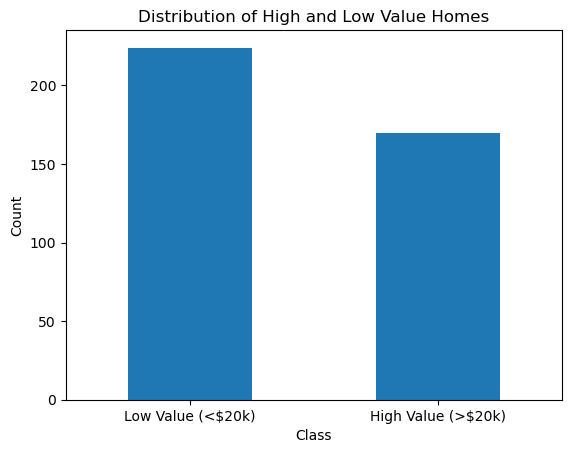

In [9]:
# Calculate the counts of high and low-value homes
class_counts = housing_data['HighValue'].value_counts()

# Create a bar chart
class_counts.plot(kind='bar')

# Set the title and labels
plt.title('Distribution of High and Low Value Homes')  # Set the title of the plot
plt.xlabel('Class')                                    # Label for the x-axis
plt.ylabel('Count')                                   # Label for the y-axis
plt.xticks(ticks=[0, 1], labels=['Low Value (<$20k)', 'High Value (>$20k)'], rotation=0)  # Set x-axis labels

# Show the plot
plt.show()  # Display the bar chart


In [10]:
# Assuming the target variable column is now named 'HighValue'
X = housing_data.drop('HighValue', axis=1)
y = housing_data['HighValue'].astype('int')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate the features and labels back into one DataFrame
housing_train_data = pd.concat([y_train, X_train], axis=1)
housing_validation_data = pd.concat([y_val, X_val], axis=1)

# Save to CSV files
housing_train_data.to_csv('HousingData_train.csv', header=False, index=False)
housing_validation_data.to_csv('HousingData_validation.csv', header=False, index=False)


In [11]:
# Concatenate the features and labels for the training set into one DataFrame
housing_train_data = pd.concat([y_train, X_train], axis=1)

# Concatenate the features and labels for the validation set into one DataFrame
housing_validation_data = pd.concat([y_val, X_val], axis=1)

# Save the training data to a CSV file without headers and index
housing_train_data.to_csv('HousingData_train.csv', header=False, index=False)

# Save the validation data to a CSV file without headers and index
housing_validation_data.to_csv('HousingData_validation.csv', header=False, index=False)


In [12]:
# Define the S3 bucket and prefix where you want to store your data
bucket = sagemaker_session.default_bucket()  # Default SageMaker bucket
prefix = 'sagemaker/boston-housing/classification'  # Prefix for your data in the bucket

# Specify the paths to your local training and validation data CSV files
local_train = 'HousingData_train.csv'  # Local path to the training data file
local_validation = 'HousingData_validation.csv'  # Local path to the validation data file

# Upload the local training data to S3 with the specified bucket and prefix
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)

# Upload the local validation data to S3 with the specified bucket and prefix
validation_uri = sagemaker_session.upload_data(local_validation, bucket=bucket, key_prefix=prefix)

In [13]:
# Print the URIs of the training and validation data in Amazon S3
print("Training URI: ", train_uri)  # URI for the training data
print("Validation URI: ", validation_uri)  # URI for the validation data

Training URI:  s3://sagemaker-us-east-1-256451472834/sagemaker/boston-housing/classification/HousingData_train.csv
Validation URI:  s3://sagemaker-us-east-1-256451472834/sagemaker/boston-housing/classification/HousingData_validation.csv


# Step 4: Get the Linear Learner Image URI

In [14]:
from sagemaker import image_uris

# Retrieve the container image URI for SageMaker Linear Learner
container = image_uris.retrieve(framework='linear-learner', region=region)

# Step 5: Configure the SageMaker Linear Learner Estimator

In [15]:
# Get the number of rows and features in the housing_data DataFrame
num_rows, num_features = housing_data.shape

# Print the number of rows
print("Number of Rows:", num_rows)

# Print the number of features
print("Number of Features:", num_features)

Number of Rows: 394
Number of Features: 14


In [16]:
# Create a SageMaker Linear Learner estimator
linear_learner = sagemaker.estimator.Estimator(container,  # Container image URI for Linear Learner
                                               role,  # SageMaker execution role
                                               instance_count=1,  # Number of instances for training
                                               instance_type='ml.m5.large',  # Instance type for training
                                               output_path=f's3://{bucket}/{prefix}/output',  # S3 output path
                                               sagemaker_session=sagemaker_session)  # SageMaker session

# Set hyperparameters for Linear Learner
linear_learner.set_hyperparameters(feature_dim=13,  # Number of features (excluding the target)
                                   mini_batch_size=32,  # Batch size for training
                                   predictor_type='binary_classifier',  # Type of predictor (classification)
                                   normalize_data=True,  # Normalize input features
                                   normalize_label=False)  # Do not normalize target labels (binary classification)


# Step 6: Train the Model

In [17]:
# Train the Linear Learner model
linear_learner.fit({
    'train': TrainingInput(train_uri, content_type='text/csv'),  # Training data location and content type
    'validation': TrainingInput(validation_uri, content_type='text/csv')  # Validation data location and content type
})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-02-06-12-43-39-506


2024-02-06 12:43:39 Starting - Starting the training job...
2024-02-06 12:43:55 Starting - Preparing the instances for training.........
2024-02-06 12:45:14 Downloading - Downloading input data...
2024-02-06 12:46:01 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/06/2024 12:47:15 INFO 140355996714816] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_d

# Step 7: Deploy the Endpoint

## Check to see if the Endpoint exists and if it does delete it

In [18]:
EndpointConfig="classification-linear-learner-endpoint"
Endpoint="classification-linear-learner-endpoint"

In [22]:
import boto3

def delete_sagemaker_endpoint(endpoint_name):
    # Initialize SageMaker client
    sagemaker = boto3.client('sagemaker', region_name=region)
    
    try:
        # Check if the endpoint configuration exists
        response = sagemaker.describe_endpoint_config(EndpointConfigName=endpoint_name)
        
        # If the configuration exists, delete it
        if response:
            sagemaker.delete_endpoint_config(EndpointConfigName=endpoint_name)
            print(f"Endpoint configuration '{endpoint_name}' has been deleted.")
        
        # Check if the endpoint exists
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        
        # If the endpoint exists, delete it
        if response:
            sagemaker.delete_endpoint(EndpointName=endpoint_name)
            print(f"Endpoint '{endpoint_name}' has been deleted.")
        
        return True  # Deletion successful
    except Exception as e:
        error_message = str(e)
        if "Could not find endpoint configuration" in error_message:
            print(f"Endpoint configuration '{endpoint_name}' not found. No action taken.")
            return True  # Configuration not found, exit gracefully
        elif "Could not find endpoint" in error_message:
            print(f"Endpoint '{endpoint_name}' not found. No action taken.")
            return True  # Endpoint not found, exit gracefully
        else:
            print(f"Error deleting SageMaker endpoint and configuration: {error_message}")
            return False  # Deletion failed

In [23]:
# Delete the Endpoint and Config

result = delete_sagemaker_endpoint(Endpoint)
if result:
    print(f"Endpoint '{Endpoint}' and its configuration have been deleted.")
else:
    print(f"Failed to delete endpoint '{Endpoint}' and its configuration.")

Endpoint configuration 'classification-linear-learner-endpoint' has been deleted.
Endpoint 'classification-linear-learner-endpoint' not found. No action taken.
Endpoint 'classification-linear-learner-endpoint' and its configuration have been deleted.


In [24]:
import boto3

# Create a SageMaker client using Boto3
sagemaker_client = boto3.client('sagemaker')

# Deploy the Linear Learner model as an endpoint
linear_predictor = linear_learner.deploy(
    initial_instance_count=1,  # Number of initial instances
    instance_type='ml.m5.large',  # Type of instance for serving
    endpoint_name=Endpoint  # Custom endpoint name
)

INFO:sagemaker:Creating model with name: linear-learner-2024-02-06-12-49-35-561
INFO:sagemaker:Creating endpoint-config with name classification-linear-learner-endpoint
INFO:sagemaker:Creating endpoint with name classification-linear-learner-endpoint


------!

# Step 8: Query the Endpoint

In [25]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set the serializer to CSV (Comma-Separated Values)
linear_predictor.serializer = CSVSerializer()

# Set the deserializer to JSON (JavaScript Object Notation)
linear_predictor.deserializer = JSONDeserializer()

In [26]:
# Sample hardcoded data point
sample_data = [0.00632, 18.0, 2.31, 0, 0.538, 6.575, 65.2, 4.09, 1, 296, 15.3, 396.9, 4.98]

# Convert the sample data to a comma-separated string
query_data_csv = ','.join([str(item) for item in sample_data])

# Querying the model and getting a prediction
response = linear_predictor.predict(query_data_csv)

# Print out the predicted class
print("Predicted class:", response['predictions'][0]['predicted_label'])

Predicted class: 1


# Step 9: Delete the Endpoint and Config

In [ ]:
# Delete the Endpoint and Config

result = delete_sagemaker_endpoint(Endpoint)
if result:
    print(f"Endpoint '{Endpoint}' and its configuration have been deleted.")
else:
    print(f"Failed to delete endpoint '{Endpoint}' and its configuration.")